### Description
This task aims to verify if there is statistically significant effect on the revenue of a dating app after increasing the price of a premium subscription. The A/A and subsequently A/B testing were conducted and the data recorded.<br>
#### Plan
The Average Revenue per Paying User (ARPPU) was chosen to evaluate, because paying users are only a small part of a total. Plus, since the premium subscription price was increased, it is unlikely that non-paying users will be attracted by it to become premium in the future.<br>
Data: Two Control and one Treatment group. User Profile and User Transactions datasets.<br>
Subcategories of users: users from Europe and from North America<br>
Parameters and methods used:<br>
&nbsp;&nbsp;• alpha(α) is set to 0.05 (the probability of a false positive is 5%)<br>
&nbsp;&nbsp;• t-test, bootstrap

__H0:__ The Null Hypothesis is that there is no significant difference between the mean revenues of the Control (A1 and A2) and Treatment (B) groups.

In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import ttest_ind, norm
from scipy import stats

sns.set()

In [68]:
# User Transactions
transactions_control1_url = 'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/84jzzJeQ4tqVyg'
transactions_control2_url = 'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/_pOo7mrDCZZMyA'
transactions_test_url = 'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/3viYBnm7cyihkQ'

In [69]:
# User Profiles
users_control1_url = 'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/TxOD_JxnkMd4mA'
users_control2_url = 'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/YT6OWRK2cTWfLg'
users_test_url = 'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/L8HxRYDn2l4h9A'

In [71]:
# Load files
transactions_A1 = pd.read_csv(transactions_control1_url, sep=';', parse_dates=['joined_at', 'paid_at'])
transactions_A2 = pd.read_csv(transactions_control2_url, sep=';', parse_dates=['joined_at', 'paid_at'])
transactions_B = pd.read_csv(transactions_test_url, sep=';', parse_dates=['joined_at', 'paid_at'])
users_A1 = pd.read_csv(users_control1_url, sep=';')
users_A2 = pd.read_csv(users_control2_url, sep=';')
users_B = pd.read_csv(users_test_url, sep=';')

### Explore the data

In [72]:
# Check for NA
transactions_A1.isna().sum()

uid             630
country         630
joined_at       630
paid_at         630
revenue         630
payment_id      630
from_page       630
product_type    630
dtype: int64

In [73]:
# Drop NAs in A1
transactions_A1 = transactions_A1.dropna()

In [74]:
# Types
users_A1.dtypes

uid                   int64
age                   int64
attraction_coeff      int64
coins               float64
country              object
visit_days           object
gender                int64
age_filter_start      int64
age_filter_end        int64
views_count           int64
was_premium         float64
is_premium          float64
total_revenue         int64
dtype: object

In [75]:
transactions_B.dtypes

uid                      int64
country                 object
joined_at       datetime64[ns]
paid_at         datetime64[ns]
revenue                  int64
payment_id               int64
from_page               object
product_type            object
dtype: object

In [76]:
# change types in transactions_A1, A2, B
transactions_A1.astype = transactions_A1.astype({'uid': 'int', 'revenue': 'int', 'payment_id': 'int', 
                                                 'country': 'string', 'from_page': 'string', 'product_type': 'string'})
transactions_A2.astype = transactions_A2.astype({'country': 'string', 'from_page': 'string', 'product_type': 'string'})
transactions_B.astype = transactions_B.astype({'country': 'string', 'from_page': 'string', 'product_type': 'string'})

In [77]:
# change types in users_A1, A2, B
users_A1 = users_A1.astype({'country': 'string', 'visit_days': 'string'})
users_A2 = users_A2.astype({'country': 'string', 'visit_days': 'string'})
users_B = users_B.astype({'country': 'string', 'visit_days': 'string'})

In [78]:
# View data
display(transactions_A1, users_A1)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891319275.0,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727.0,147.0,trial_vip_popup,trial_premium
1,892421826.0,Israel,2017-10-14 12:46:00,2017-10-23 12:54:00,14586.0,147.0,trial_vip_popup,trial_premium
2,891822480.0,Italy,2017-10-26 22:27:00,2017-12-11 20:59:00,1911.0,19.0,none,coins
3,891367521.0,Italy,2017-05-11 02:37:00,2017-06-11 19:15:00,1456.0,127.0,sympathy,other_type
4,892207959.0,France,2017-10-18 18:30:00,2017-12-11 12:03:00,1261.0,19.0,empty_likes,coins
...,...,...,...,...,...,...,...,...
372,891556971.0,France,2017-01-11 05:07:00,2017-01-11 05:16:00,2886.0,68.0,none,premium_no_trial
373,892052106.0,Spain,2017-10-22 01:38:00,2017-10-29 03:44:00,12883.0,147.0,trial_vip_popup,trial_premium
374,892145004.0,Chile,2017-10-20 04:25:00,2017-01-11 02:56:00,9919.0,147.0,trial_vip_popup,trial_premium
375,891458229.0,Spain,2017-03-11 12:12:00,2017-04-11 03:43:00,6305.0,19.0,menu,coins


,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892319115,25,435,NaN,United States of America,"1,2,3,4,5,6",0,22,32,982,NaN,NaN,0
1,891248523,29,500,NaN,United States of America,"1,2",1,26,32,12,NaN,NaN,0
2,891670932,33,800,NaN,France,"1,2,3,5,6,8,9,11,13,16",1,30,36,5,NaN,NaN,0
3,891060786,26,0,NaN,Argentina,"1,2,3,4,5",1,23,29,0,NaN,NaN,0
4,892006554,35,294,NaN,United States of America,"1,2,3,5,6,7,8,9,10,12,15,16,17,19",1,30,40,17,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4335,892022304,26,227,NaN,United States of America,<NA>,0,23,29,427,NaN,NaN,0
4336,891905022,38,200,NaN,Argentina,"1,2,3,4,5,6,7,8,9,10,11,13,14,15,16,21",1,20,50,5,NaN,NaN,0
4337,891304722,49,411,NaN,United States of America,1,1,46,52,17,NaN,NaN,0
4338,891302328,27,0,NaN,United States of America,"1,3,5",1,24,30,0,NaN,NaN,0


In [79]:
# Check what is NaN
users_A1.coins.value_counts().min()

1

In [80]:
users_A1.was_premium.value_counts()

1.0    436
Name: was_premium, dtype: int64

In [81]:
# coins NaN to 0
users_A1['coins'] = users_A1['coins'].fillna(0)
users_A2['coins'] = users_A2['coins'].fillna(0)
users_B['coins'] = users_B['coins'].fillna(0)

In [82]:
# was_premium and is_premium NaN to 0
users_A1['was_premium'] = users_A1['was_premium'].fillna(0)
users_A2['was_premium'] = users_A2['was_premium'].fillna(0)
users_B['was_premium'] = users_B['was_premium'].fillna(0)

users_A1['is_premium'] = users_A1['is_premium'].fillna(0)
users_A2['is_premium'] = users_A2['is_premium'].fillna(0)
users_B['is_premium'] = users_B['is_premium'].fillna(0)

#### Outliers

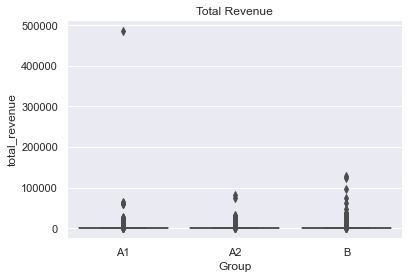

In [84]:
# Check for outliers in users.total_revenue
users_A1 = users_A1.assign(Group="A1")
users_A2 = users_A2.assign(Group="A2")
users_B = users_B.assign(Group="B")

# New dataframe Groups 3in1
u = pd.concat([users_A1, users_A2, users_B])

sns.boxplot(x="Group", y="total_revenue", data=u).set_title('Total Revenue')
sns.despine()

In [85]:
# check extreme values profile. id 892333905
users_A1.query('total_revenue >200000')

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,Group
1427,892333905,22,175,3608.0,Italy,"1,2,3,4,5,6,7,15",1,19,25,575,1.0,1.0,486330,A1


In [86]:
# check user id 892333905 transactions (revenue and dates)
transactions_A1.query('uid == 892333905').sort_values(by='paid_at')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
49,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:42:00,3783.0,67.0,menu,other_type
13,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:44:00,3783.0,67.0,menu,other_type
47,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:44:00,3783.0,67.0,menu,other_type
169,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:44:00,3783.0,67.0,menu,other_type
28,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:57:00,3783.0,67.0,empty_admins,other_type
296,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:57:00,3783.0,67.0,empty_admins,other_type
43,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:58:00,3783.0,67.0,empty_admins,other_type
198,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:58:00,3783.0,67.0,empty_admins,other_type
88,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:58:00,3783.0,67.0,empty_admins,other_type
6,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 02:08:00,12610.0,19.0,gifts,coins


In [87]:
# Remove this outlier, user from users and transactions
u = u.query('uid != 892333905')
transactions_A1 = transactions_A1.query('uid != 892333905')

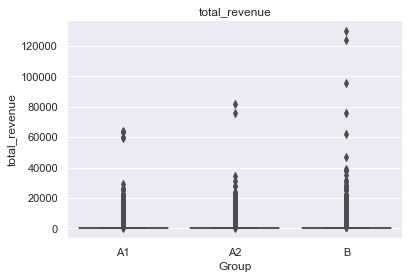

In [89]:
# boxplot of the new total_revenue
sns.boxplot(x="Group", y="total_revenue", data=u).set_title('total_revenue')
sns.despine()

 *** 
## Part 1
Verify if the test was conducted successfully.<br>
Prior to A/B test run A/A test to assess if there is mismatch between Control and Treatment groups, which can affect the result. The idea is to accept the Null hypothesis that A1 = A2.  

In [90]:
# New dfs for Paying Users
uA1 = users_A1.query('total_revenue > 0')
uA2 = users_A2.query('total_revenue > 0')
uB = users_B.query('total_revenue > 0')

### Simulation of new A/A tests
Use sampling without replacement and calculate p-values with t-test. We expect the resulting distribution of p-values be uniformly distributed. As such we calculate the FPR and check if it does not exceed α (0.05).

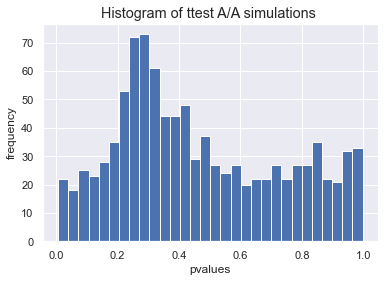

FPR 0.028


In [91]:
# Check Control A1 and Control A2 in A/A simulations using t-test
simulations = 1000
n_s = 40
res = []

sample_A1 = uA1.total_revenue
sample_A2 = uA2.total_revenue

# A/A subsampling
for i in range(simulations):
    s1 = sample_A1.sample(n_s, replace=False).values
    s2 = sample_A2.sample(n_s, replace=False).values
    res.append(stats.ttest_ind(s1, s2, equal_var=False)[1])

plt.hist(res, bins=30)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Check if FPR < α
print('FPR', sum(np.array(res) < 0.05) / simulations)

### A/B test results analysis - Hypothesis testing 

To compare groups using Student's t-test first apply Shapiro–Wilk test to check for normality of sample distributions. In case requirements are not met  the distributions of the total_revenues are log-transformed. Alternatively bootstrap method is used.

In [92]:
# Revenues from paying users in Groups:
u.query('total_revenue > 0').groupby('Group').total_revenue.describe()  \
    .style.set_properties(**{'background-color': '#efdecd'}, subset=['mean'])

,count,mean,std,min,25%,50%,75%,max
Group,,,,,,,,
A1,191.000000,10968.256545,9973.321815,26.000000,5973.500000,9139.000000,12870.000000,64298.000000
A2,187.000000,10269.721925,9272.960475,481.000000,6064.500000,7969.000000,12727.000000,81796.000000
B,146.000000,15759.027397,18058.118399,624.000000,8248.500000,12727.000000,16428.750000,129870.000000


In [93]:
# Normality test
print(f'{stats.shapiro(uA1.total_revenue)},\n{stats.shapiro(uA2.total_revenue)},\n{stats.shapiro(uB.total_revenue)}')

ShapiroResult(statistic=0.17460763454437256, pvalue=2.655617133549436e-28),
ShapiroResult(statistic=0.6258848905563354, pvalue=5.0175247612037996e-20),
ShapiroResult(statistic=0.5494610071182251, pvalue=2.530081054497636e-19)


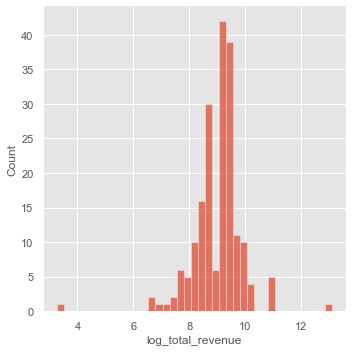

In [94]:
# Log transformation
uA1 = uA1.assign(log_total_revenue=np.log(uA1.total_revenue))
sns.displot(uA1.log_total_revenue)

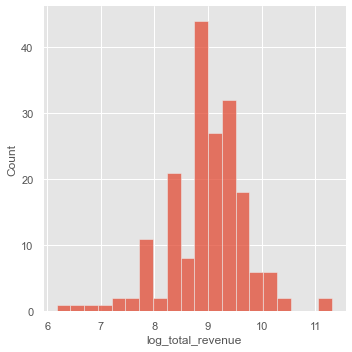

In [95]:
uA2 = uA2.assign(log_total_revenue=np.log(uA2.total_revenue))
sns.displot(uA2.log_total_revenue)

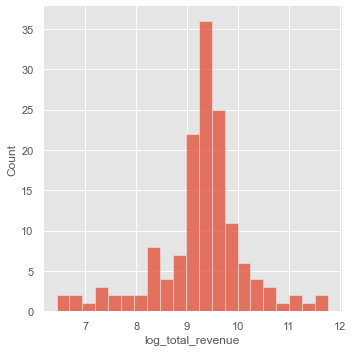

In [96]:
uB = uB.assign(log_total_revenue=np.log(uB.total_revenue))
sns.displot(uB.log_total_revenue)

#### T-test

In [97]:
# Unite Control groups in one (A1+A2)
uA12 = pd.concat([uA1, uA2])

# Compare the means of groups with t-test
print(ttest_ind(uA1.log_total_revenue, uA2.log_total_revenue))
print(ttest_ind(uA12.log_total_revenue, uB.log_total_revenue))

Ttest_indResult(statistic=0.6439978423752836, pvalue=0.5199684247563092)
Ttest_indResult(statistic=-3.545665220131177, pvalue=0.0004267723184959417)


#### Bootstrap

In [98]:
# Create get_bootstrap function
def get_bootstrap(sample1, sample2, boot_it=1000, statistic=np.mean, bootstrap_conf_level=0.95):
    boot_len = max([len(sample1), len(sample2)])
    boot_data = [] 
    for i in range(boot_it): 
        samples_1 = sample1.sample(boot_len, replace=True).values
        samples_2 = sample2.sample(boot_len, replace=True).values
        
        boot_data.append(statistic(samples_1 - samples_2))
                  
    p_1 = norm.cdf(x=0, loc=np.mean(boot_data), scale=np.std(boot_data))
    p_2 = norm.cdf(x=0, loc=-np.mean(boot_data), scale=np.std(boot_data))
    p_value = min(p_1, p_2) * 2

    return {"p_value": p_value}

In [99]:
AA = get_bootstrap(uA1.total_revenue, uA2.total_revenue)
AB = get_bootstrap(uA12.total_revenue, uB.total_revenue)
print('p-value:')
print(f'Control A1 and Control A2: {AA["p_value"]}')
print(f'Control(A1 + A2) and Treatment(B): {AB["p_value"]}')
print('- reject Null Hypothesis' if AA["p_value"] > 0.05 and AB["p_value"] <= 0.05 else '- accept Null Hypothesis')

p-value:
Control A1 and Control A2: 0.2438419365424973
Control(A1 + A2) and Treatment(B): 0.018330447017359787
- reject Null Hypothesis


 *** 
## Part 2
Analyze the subcategories to find out whether the changes have a significant effect on specific user categories.<br>

There are users from Europe and North America. When comparing subcategories α is adjusted to account for the number of comparisons made. This will reduce the probability of committing a type I error. Alpha is thus equal to 0.025.

#### ARPPU from Premium Subscription only
We will analyse Average Revenue Per Users from buying Premium Subscription, product_type is _"premium_no_trial"_ (Subscription ARPPU). After increasing the price it is possible that users cancel their premium membership.<br>
__H0:__ The ARPPU from Premium Subscription in Control groups does not differ significantly from the Treatment group.<br>
__H1:__ The effect can be present in case Treatment users will continue to pay for premium subscription with a new price, therefore their Total Revenue will be greater than that of Control users.

In [100]:
# Assign Groups
transactions_A1 = transactions_A1.assign(Group="A1")
transactions_A2 = transactions_A2.assign(Group="A2")
transactions_B = transactions_B.assign(Group="B")

transactions = pd.concat([transactions_A1, transactions_A2, transactions_B])

In [101]:
# Merge to get information about subscription type
transactions = transactions.merge(u[['uid', 'is_premium']], on='uid', how='left')

In [102]:
# Assign regions
region_cond = [
    (transactions['country'].isin(['United States of America', 'Canada'])),
    (transactions['country'].isin(['France', 'Italy', 'Spain', 'United Kingdom (Great Britain)', 
                                   'Germany', 'Portugal', 'Switzerland', 'Belgium', 'Ukraine', 'Latvia', 
                                   'Austria', 'Lithuania', 'Russian Federation'])),
    (transactions['country'].isin(['Argentina', 'Chile', 'Mexico', 'Turkey', 'Israel', 'United Arab Emirates', 'India', 'Australia']))
]

In [103]:
region_name = ['NA', 'EU', 'other']

In [104]:
transactions['region'] = np.select(region_cond, region_name)

In [105]:
transactions.head(3)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,Group,is_premium,region
0,891319275.0,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727.0,147.0,trial_vip_popup,trial_premium,A1,1.0,EU
1,892421826.0,Israel,2017-10-14 12:46:00,2017-10-23 12:54:00,14586.0,147.0,trial_vip_popup,trial_premium,A1,1.0,other
2,891822480.0,Italy,2017-10-26 22:27:00,2017-12-11 20:59:00,1911.0,19.0,none,coins,A1,1.0,EU


In [106]:
# Filter the data to have only premium users from North America and Europe
transactions_premium = transactions.query('is_premium == 1.0 & product_type == "premium_no_trial" & region == ["EU", "NA"]') \
 .groupby(['uid', 'Group', 'region'], as_index=False).agg({'revenue': 'sum'}).sort_values(by='Group')

transactions_premium

,uid,Group,region,revenue
141,892216461.0,A1,NA,63037.0
139,892207959.0,A1,EU,6292.0
106,892042395.0,A1,NA,4537.0
36,891365490.0,A1,NA,6292.0
136,892204314.0,A1,EU,6292.0
...,...,...,...,...
140,892211106.0,B,EU,4537.0
33,891325683.0,B,NA,4719.0
142,892217373.0,B,NA,7904.0
59,891564672.0,B,EU,6292.0


In [107]:
# Check the size of samples
transactions_premium = transactions.query('product_type == "premium_no_trial" & region == ["EU", "NA"]') \
 .groupby(['uid', 'Group', 'region'], as_index=False).agg({'revenue': 'sum'})
transactions_premium.groupby('Group').uid.count()

Group
A1    70
A2    82
B     47
Name: uid, dtype: int64

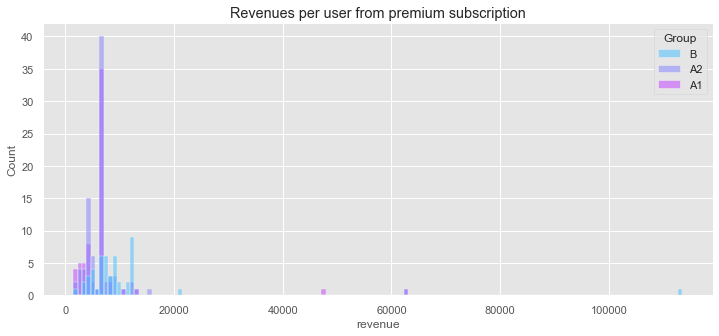

In [108]:
# Check distributions
plt.figure(figsize=(12,5))
sns.histplot(data=transactions_premium, x='revenue', hue='Group', palette='cool').set_title('Revenues per user from premium subscription')
sns.despine()

In [109]:
# Statistics for revenues per user from premium subscription for each testing group
(transactions_premium.groupby(['Group', 'uid'], as_index=False).agg({'revenue': 'sum'})
 .groupby('Group').revenue.describe()
 .style.set_properties(**{'background-color': '#efdecd'}, subset=['mean']))

,count,mean,std,min,25%,50%,75%,max
Group,,,,,,,,
A1,70.000000,7190.485714,8716.346834,1508.000000,4537.000000,6292.000000,6418.750000,63037.000000
A2,82.000000,6568.487805,6640.159044,1482.000000,4537.000000,6292.000000,6353.750000,63037.000000
B,47.000000,10651.702128,15720.487324,1898.000000,6292.000000,7904.000000,11362.000000,113477.000000


#### Hypothesis testing 

In [110]:
# Compare the means of groups with t-test
print(ttest_ind(transactions_premium.query('Group != "B"').revenue, transactions_premium.query('Group == "B"').revenue))

Ttest_indResult(statistic=-2.246745559392231, pvalue=0.025765766889225095)


In [111]:
# Bootstrap
AA = get_bootstrap(transactions_premium.query('Group == "A1"').revenue, transactions_premium.query('Group == "A2"').revenue)
AB = get_bootstrap(transactions_premium.query('Group != "B"').revenue, transactions_premium.query('Group == "B"').revenue)
print('p-values:')
print(f'Control A1 and Control A2: {AA["p_value"]}')
print(f'Control(A1 + A2) and Treatment(B): {AB["p_value"]}')
print('- reject Null Hypothesis' if AA["p_value"] > 0.05 and AB["p_value"] < 0.05 else '- accept Null Hypothesis')

p-values:
Control A1 and Control A2: 0.596232459969559
Control(A1 + A2) and Treatment(B): 0.006290861294662773
- reject Null Hypothesis


#### by region

In [112]:
# Statistics by region
transactions_premium.groupby(['Group', 'region']).revenue.describe() \
    .style.set_properties(**{'background-color': '#efdecd'}, subset=['mean'])

#### Hypothesis testing 

In [113]:
# North America
AA = get_bootstrap(transactions_premium.query('Group == "A1" & region == "NA"').revenue, 
                     transactions_premium.query('Group == "A2" & region == "NA"').revenue)
AB = get_bootstrap(transactions_premium.query('Group == ["A1", "A2"] & region == "NA"').revenue,
                     transactions_premium.query('Group == "B" & region == "NA"').revenue)
print('p-values:')
print(f'Control A1 and Control A2: {AA["p_value"]}')
print(f'Control(A1 + A2) and Treatment(B): {AB["p_value"]}')
print('- reject Null Hypothesis' if AA["p_value"] > 0.25 and AB["p_value"] <= 0.25 else '- accept Null Hypothesis')

p-values:
Control A1 and Control A2: 0.12772551927014839
Control(A1 + A2) and Treatment(B): 0.10638704758316307
- accept Null Hypothesis


In [114]:
# Europe
AA = get_bootstrap(transactions_premium.query('Group == "A1" & region == "EU"').revenue, 
                     transactions_premium.query('Group == "A2" & region == "EU"').revenue)
AB = get_bootstrap(transactions_premium.query('Group == ["A1", "A2"] & region == "EU"').revenue,
                     transactions_premium.query('Group == "B" & region == "EU"').revenue)
print('p-values:')
print(f'Control A1 and Control A2: {AA["p_value"]}')
print(f'Control(A1 + A2) and Treatment(B): {AB["p_value"]}')
print('- reject Null Hypothesis' if AA["p_value"] > 0.25 and AB["p_value"] <= 0.025 else '- accept Null Hypothesis')

p-values:
Control A1 and Control A2: 0.3089266425736047
Control(A1 + A2) and Treatment(B): 0.01920402105132994
- reject Null Hypothesis


 *** 
### Revenue per user from Premium subscription + Coins

__H0:__ Probably users from Treatment buy less coins, since the subscription price is already high (higher than for Control groups) they don't want to spend additional money on this feature, and thus the total revenue from subscription and coins doesn't differ from Control groups (where users can afford to spend some more money and additionally buy coins).

In [115]:
transactions.head(3)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,Group,is_premium,region
0,891319275.0,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727.0,147.0,trial_vip_popup,trial_premium,A1,1.0,EU
1,892421826.0,Israel,2017-10-14 12:46:00,2017-10-23 12:54:00,14586.0,147.0,trial_vip_popup,trial_premium,A1,1.0,other
2,891822480.0,Italy,2017-10-26 22:27:00,2017-12-11 20:59:00,1911.0,19.0,none,coins,A1,1.0,EU


In [116]:
transactions_pc = transactions.query('is_premium == 1.0 & product_type == ["premium_no_trial", "coins"] & region != "other"') \
 .groupby(['uid', 'Group', 'region'], as_index=False).agg({'revenue': 'sum'}).sort_values(by='Group')
transactions_pc

,uid,Group,region,revenue
161,892216461.0,A1,NA,64298.0
61,891543996.0,A1,NA,6292.0
58,891522666.0,A1,EU,4056.0
56,891503397.0,A1,EU,6448.0
118,892011654.0,A1,NA,2119.0
...,...,...,...,...
82,891692940.0,B,NA,9100.0
75,891654090.0,B,NA,19500.0
71,891615909.0,B,EU,6279.0
104,891907887.0,B,NA,4706.0


In [117]:
# Check the size of samples
transactions_pc.groupby('Group').uid.count()

Group
A1    65
A2    77
B     54
Name: uid, dtype: int64

In [118]:
transactions_pc \
    .groupby(['Group', 'region', 'uid']).agg({'revenue': 'sum'}) \
    .groupby(['Group', 'region']).revenue.describe() \
    .style.set_properties(**{'background-color': '#efdecd'}, subset=['mean'])

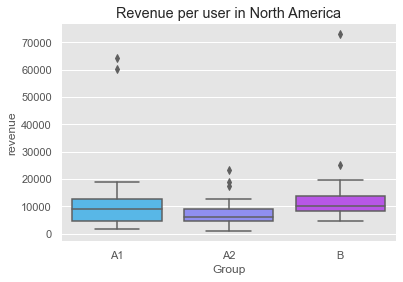

In [119]:
sns.boxplot(x='Group', y='revenue', data=transactions_pc[transactions_pc['region'] == "NA"], palette='cool') \
.set_title('Revenue per user in North America')
sns.despine()

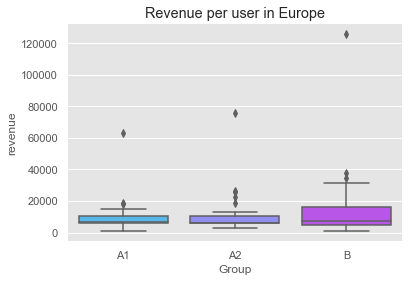

In [120]:
sns.boxplot(x='Group', y='revenue', data=transactions_pc[transactions_pc['region'] == "EU"], palette='cool') \
.set_title('Revenue per user in Europe')
sns.despine()

In [121]:
transactions_pc['Groups'] = np.where(transactions_pc.Group == "B", "B", "AA")
transactions_pc

,uid,Group,region,revenue,Groups
161,892216461.0,A1,NA,64298.0,AA
61,891543996.0,A1,NA,6292.0,AA
58,891522666.0,A1,EU,4056.0,AA
56,891503397.0,A1,EU,6448.0,AA
118,892011654.0,A1,NA,2119.0,AA
...,...,...,...,...,...
82,891692940.0,B,NA,9100.0,B
75,891654090.0,B,NA,19500.0,B
71,891615909.0,B,EU,6279.0,B
104,891907887.0,B,NA,4706.0,B


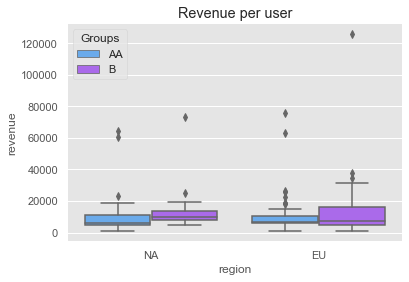

In [122]:
sns.boxplot(x='region', y='revenue', data=transactions_pc, hue='Groups', palette='cool') \
.set_title('Revenue per user')
sns.despine()

#### Hypothesis testing 

In [123]:
# North America
AA = get_bootstrap(transactions_pc.query('Group == "A1" & region == "NA"').revenue, 
                     transactions_pc.query('Group == "A2" & region == "NA"').revenue)
AB = get_bootstrap(transactions_pc.query('Group == ["A1", "A2"] & region == "NA"').revenue,
                     transactions_pc.query('Group == "B" & region == "NA"').revenue)
print('p-values:')
print(f'Control A1 and Control A2: {AA["p_value"]}')
print(f'Control(A1 + A2) and Treatment(B): {AB["p_value"]}')
print('- reject Null Hypothesis' if AA["p_value"] > 0.025 and AB["p_value"] <= 0.025 else '- accept Null Hypothesis')

p-values:
Control A1 and Control A2: 0.05066204055773784
Control(A1 + A2) and Treatment(B): 0.06636638137457468
- accept Null Hypothesis


In [124]:
# Check Europe
AA = get_bootstrap(transactions_pc.query('Group == "A1" & region == "EU"').revenue, 
                     transactions_pc.query('Group == "A2" & region == "EU"').revenue)
AB = get_bootstrap(transactions_pc.query('Group == ["A1", "A2"] & region == "EU"').revenue,
                     transactions_pc.query('Group == "B" & region == "EU"').revenue)
print('p-values:')
print(f'Control A1 and Control A2: {AA["p_value"]}')
print(f'Control(A1 + A2) and Treatment(B): {AB["p_value"]}')
print('- reject Null Hypothesis' if AA["p_value"] > 0.025 and AB["p_value"] <= 0.025 else '- accept Null Hypothesis')

p-values:
Control A1 and Control A2: 0.895972166936962
Control(A1 + A2) and Treatment(B): 0.07793884131971003
- accept Null Hypothesis


***
## Conclusion
The A/A test results show that the groups were equally and randomly split.<br>
Changing the price for premium subscription makes sense for Europe (p-value < 0.025). For North America however the test shows that there is no significant effect on ARPPU.<br>
If to analyze ARPPU considering both revenues from Premium subscription and from Coins significant difference is not observed.